### Import libraries

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pymc as pm
from aux_functions.mcmc_transformations import (import_dataset, transform_variables, pop_variable, convert_to_float, normalize_dataset)
from aux_functions.mcmc_corr_matrix import (get_ordered_correlation_matrix, plot_correlation_matrix)
from aux_functions.mcmc_modelling import (get_specified_dfs, get_models, sample_models, get_identified_sampling_results, get_waic_measures, get_model_from_list)


### Define parameters for data transformation

In [2]:
# Importing dataset
path = "data/dataset.txt"
column_names = ['lenght_of_stay', 'age', 'infection_risk', 'routine_culturing_ratio', 'routine_xray_ratio', 'num_beds', 'med_school_affil', 'region', 'avg_census', 'num_nurses', 'avelbl_services']
columns_to_dummify = ['med_school_affil', 'region']
columns_to_apply_ln = ['num_nurses', 'num_beds', 'avg_census']
result_path = './imgs/results/'
target_variable = 'infection_risk'

### Define parameters for models to fit and compare

In [3]:
# Uncomment which models you wish to create
variables_of_dfs_to_build = {
    'df_complete':['routine_culturing_ratio', 'ln_num_nurses', 'lenght_of_stay', 'ln_avg_census', 'routine_xray_ratio', 'ln_num_beds', 'avelbl_services', 'med_school_affil_1', 'region_1', 'region_2', 'region_4', 'age', 'region_3', 'med_school_affil_2'],
    'df_top_8': ['routine_culturing_ratio', 'ln_num_nurses', 'lenght_of_stay', 'ln_avg_census', 'routine_xray_ratio', 'ln_num_beds', 'avelbl_services', 'med_school_affil_1', 'med_school_affil_2'],
    'df_top_5': ['routine_culturing_ratio', 'ln_num_nurses', 'lenght_of_stay', 'ln_avg_census', 'routine_xray_ratio'],
    'df_top_4': ['routine_culturing_ratio', 'ln_num_nurses', 'lenght_of_stay', 'ln_avg_census'],
    'df_top_3': ['routine_culturing_ratio', 'ln_num_nurses', 'lenght_of_stay'],
    'df_top_2': ['routine_culturing_ratio', 'ln_num_nurses',]
}
models_names = variables_of_dfs_to_build.keys()

number_of_samples = 100_000

### Run transformation pipeline

In [4]:
df = import_dataset(path, column_names)
df = transform_variables(df, columns_to_dummify, columns_to_apply_ln)
corr_matrix = get_ordered_correlation_matrix(df, target_variable)
plot_correlation_matrix(corr_matrix, result_path)
X, y = pop_variable(df, target_variable)
X = convert_to_float(X)
y = convert_to_float(y)
X = normalize_dataset(X)

### Create dataframes and models according to specification

In [5]:
# list in which each item is a datafram with the columns previously specified
dfs = get_specified_dfs(X, variables_of_dfs_to_build) 

In [6]:
y_proposal_distribution = "cauchy"

# list in which each item is a pm.Model() object
# Each model will have a diferent dataset ex: models[1] has the dataset[1] as covariate
models = get_models(dfs, models_names, y, y_proposal_distribution)


### Sample from models

In [7]:
# list in which each item is the sample result of each model of models
sampling_results = sample_models(number_of_samples, models)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [df_complete::alpha]
>Metropolis: [df_complete::beta]
>Metropolis: [df_complete::sigma]
>Metropolis: [df_complete::gamma]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 152 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [df_top_8::alpha]
>Metropolis: [df_top_8::beta]
>Metropolis: [df_top_8::sigma]
>Metropolis: [df_top_8::gamma]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 153 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [df_top_5::alpha]
>Metropolis: [df_top_5::beta]
>Metropolis: [df_top_5::sigma]
>Metropolis: [df_top_5::gamma]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 117 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [df_top_4::alpha]
>Metropolis: [df_top_4::beta]
>Metropolis: [df_top_4::sigma]
>Metropolis: [df_top_4::gamma]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 115 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [df_top_3::alpha]
>Metropolis: [df_top_3::beta]
>Metropolis: [df_top_3::sigma]
>Metropolis: [df_top_3::gamma]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 106 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [df_top_2::alpha]
>Metropolis: [df_top_2::beta]
>Metropolis: [df_top_2::sigma]
>Metropolis: [df_top_2::gamma]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 103 seconds.


In [8]:
# Dict with {model_name: sampling_result} for easier identification
identified_sampling_results = get_identified_sampling_results(sampling_results, models_names)

### Run WAIC tests

In [9]:
# dataframe with waic test results
dfwaic = get_waic_measures(identified_sampling_results)

/home/davi/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/davi/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/davi/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/davi/miniconda3/envs/pymc_env/lib/python3.11/site-pa

In [10]:
dfwaic[['rank','elpd_waic', 'p_waic']]

,rank,elpd_waic,p_waic
df_top_3,0,-166.192713,5.956662
df_top_5,1,-166.920863,10.235495
df_top_4,2,-167.719677,9.298165
df_complete,3,-168.643596,25.743917
df_top_8,4,-171.068002,17.888383
df_top_2,5,-174.497821,4.489570


In [11]:
# Choose model for the next analysis
selected_model = 'df_top_3'

### View summary of selected model for the current distribution

In [12]:
az.summary(identified_sampling_results[selected_model], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
df_top_3::alpha,4.28,0.07,4.15,4.41,0.00,0.00,46671.78,51276.56,1.0
df_top_3::beta[routine_culturing_ratio],0.73,0.09,0.56,0.90,0.00,0.00,37036.15,49726.35,1.0
df_top_3::beta[ln_num_nurses],0.60,0.07,0.47,0.73,0.00,0.00,33197.56,42779.78,1.0
df_top_3::beta[lenght_of_stay],0.40,0.08,0.25,0.55,0.00,0.00,35760.20,47039.03,1.0
df_top_3::sigma,7.99,6.05,0.00,18.87,0.02,0.02,64150.26,59764.06,1.0
df_top_3::gamma,0.47,0.06,0.36,0.59,0.00,0.00,56295.48,62692.70,1.0


### Forest plot

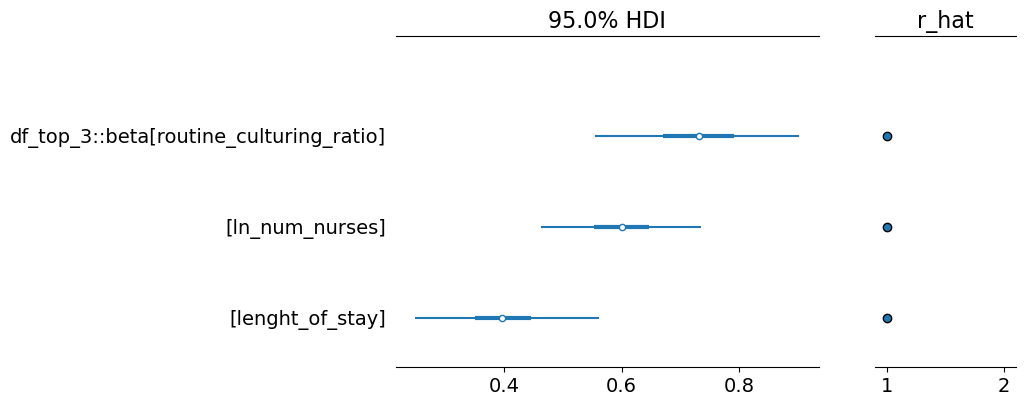

In [13]:
# Plot parameters for covariates
az.plot_forest(identified_sampling_results[selected_model], var_names=[f"{selected_model}::beta"], combined=True, hdi_prob=0.95, r_hat=True, );

### Density of posterior distributions

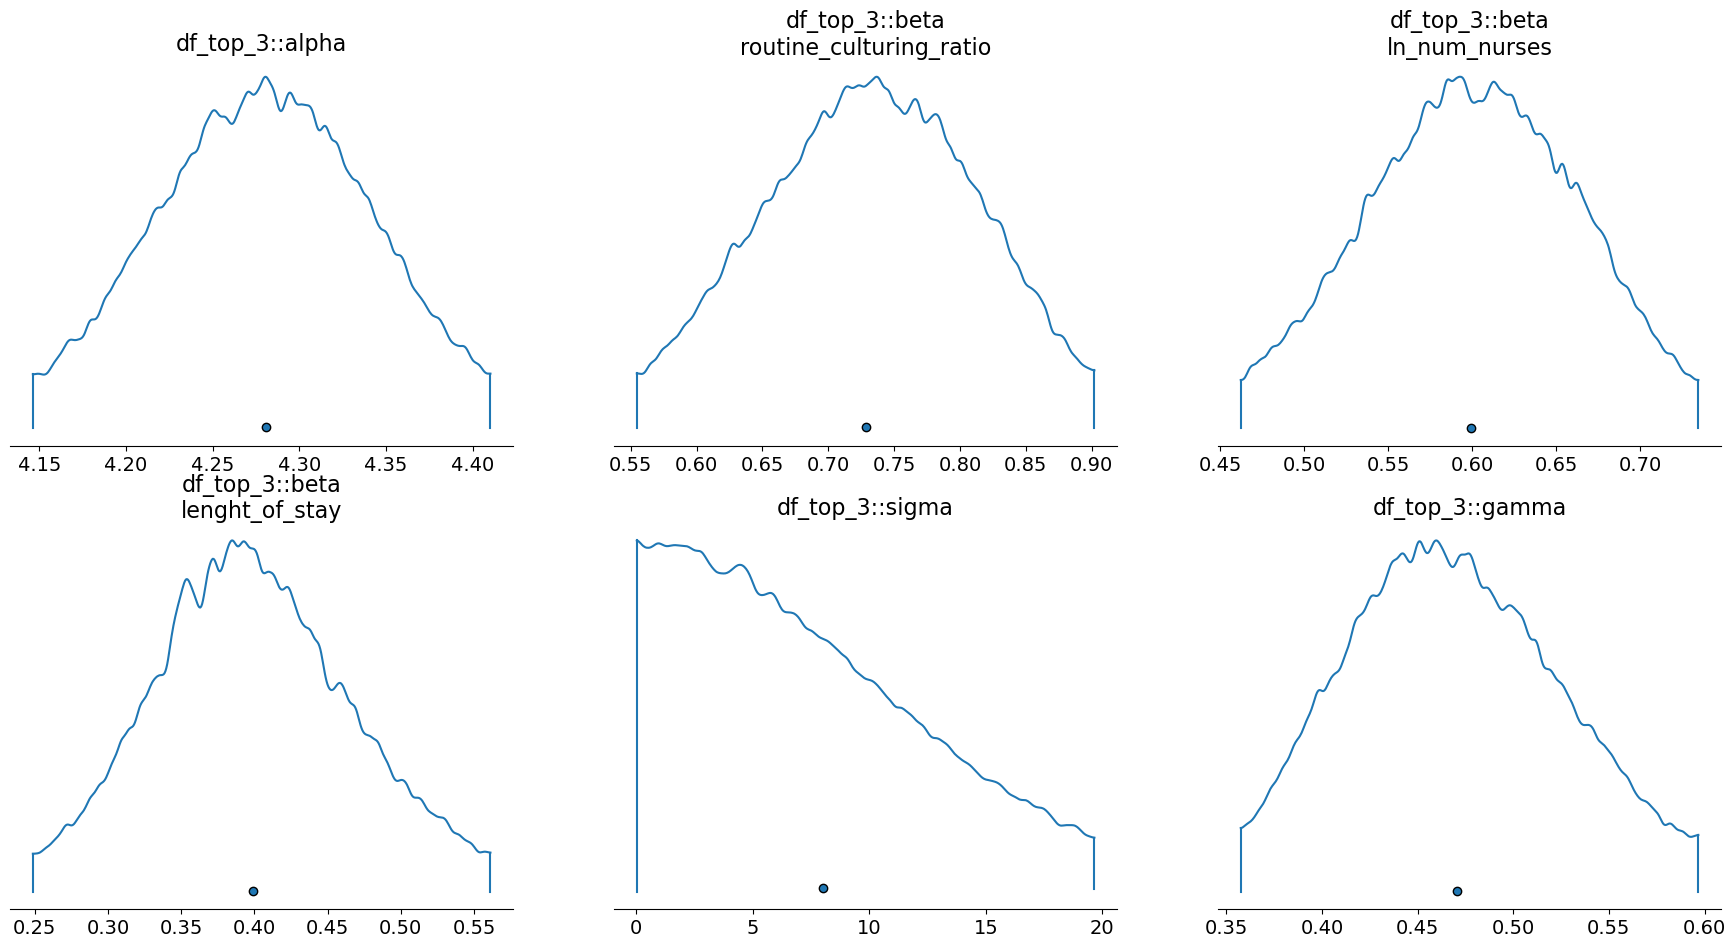

In [14]:
# Plot posterior densities of parameters
az.plot_density(identified_sampling_results[selected_model], group='posterior', hdi_prob=0.95);

### Sample and plot posterior predictive distribution

In [15]:
Y_pred = pm.sample_posterior_predictive(identified_sampling_results[selected_model], model=get_model_from_list(models, selected_model)) # for each sample it draws a beta from each found beta distribution -> finds Y_pred for all X

Sampling: [df_top_3::Y_obs]


In [16]:
with get_model_from_list(models, selected_model):
    pm.sample_posterior_predictive(identified_sampling_results[selected_model], extend_inferencedata=True)

Sampling: [df_top_3::Y_obs]


/home/davi/miniconda3/envs/pymc_env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


array([<Axes: xlabel='df_top_3::Y_obs / df_top_3::Y_obs'>], dtype=object)

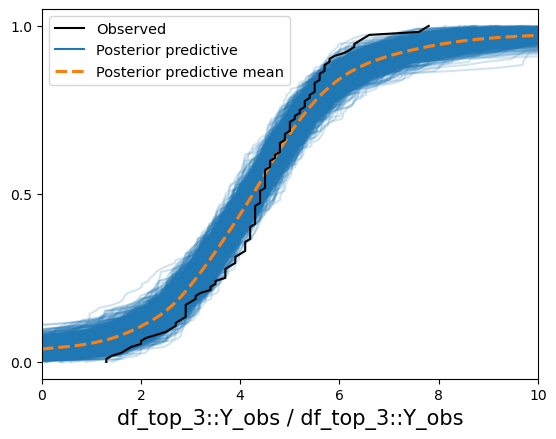

In [17]:
num_pp_samples = 1000

fig, ax = plt.subplots()
plt.xlim(0,10)
az.plot_ppc(Y_pred, num_pp_samples=num_pp_samples, kind='cumulative', ax=ax)

/home/davi/miniconda3/envs/pymc_env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


array([<Axes: xlabel='df_top_3::Y_obs / df_top_3::Y_obs'>], dtype=object)

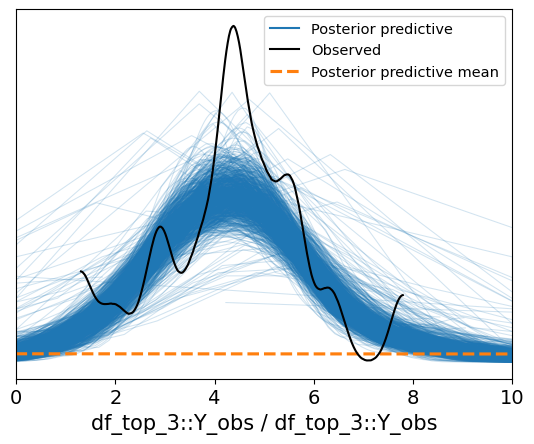

In [26]:
num_pp_samples = 1000

fig, ax = plt.subplots()
plt.xlim(0,10)
az.plot_ppc(Y_pred, num_pp_samples=num_pp_samples, ax=ax)

In [ ]:
Y_pred.posterior....